In [22]:
!pip install gdown

import gdown
import shutil

# Destination directory where the user will download the data https://drive.google.com/file/d/11PI6wGDjuJ3LiPSm3izbVcmVTX7DDVLn/view?usp=drive_link
destination_path = '/content'

# Direct download link for the ZIP file
folder_id ='11PI6wGDjuJ3LiPSm3izbVcmVTX7DDVLn'
zip_file_url = f'https://drive.google.com/uc?id={folder_id}'


# Download the ZIP file
zip_file_path = destination_path + '/Data.zip'
gdown.download(zip_file_url, zip_file_path, quiet=False)

AttributeError: 'NoneType' object has no attribute 'groups'

In [25]:
# Extract the downloaded ZIP file
shutil.unpack_archive(zip_file_path, destination_path)

print("Data has been downloaded and extracted to:", destination_path)

Data has been downloaded and extracted to: /content


In [26]:
import numpy as np

#Set the `numpy` pseudo-random generator at a fixed value
#This helps with repeatable results everytime you run the code.
np.random.seed(1000)

import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras
import tensorflow as tf

In [30]:
from keras.preprocessing.image import ImageDataGenerator

# Specify the path to your data
data_path = '/content/Data'

# Create an ImageDataGenerator with rescaling and other augmentations if needed
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Create separate generators for training, validation, and test
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(150, 150),
    batch_size=4,
    class_mode='binary',
    subset='training'  # Use subset parameter for the training set
)

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(150, 150),
    batch_size=4,
    class_mode='binary',
    subset='validation'  # Use subset parameter for the validation set
)

Found 1423 images belonging to 2 classes.
Found 158 images belonging to 2 classes.


In [31]:
import os
import cv2
import random

data_folder = '/content/Data'  # Replace with the path to your 'data' folder

# Get the list of subfolders inside the 'data' folder
subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]

for folder in subfolders:
    # Get the list of images in each subfolder
    images = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Print the number of images in the folder
    print(f"Folder: {os.path.basename(folder)} - Number of Images: {len(images)}")

    if images:
        # Randomly select one image from the folder
        random_image = random.choice(images)

        # Get the path of the randomly selected image
        image_path = os.path.join(folder, random_image)

        # Read the image using OpenCV to get its size
        img = cv2.imread(image_path)
        if img is not None:
            height, width, _ = img.shape
            print(f"  Random Image: {random_image} - Size: {width}x{height}")
        else:
            print(f"  Unable to read the image: {random_image}")

    print()  # Add a newline for better readability


Folder: empty - Number of Images: 621
  Random Image: aug_0_6283.png - Size: 68x27

Folder: not_empty - Number of Images: 960
  Random Image: aug_0_3583.png - Size: 61x26



# Data Augmentation

In [29]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm  # For progress bars

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment and save images in the same folder
def augment_and_save(input_folder, target_count,image_count):
    # Load images from the input folder
    image_list = [os.path.join(input_folder, img) for img in os.listdir(input_folder)]

    # Calculate the number of images to generate
    images_to_generate = target_count - image_count

    # Loop through the images and perform data augmentation
    for img_path in tqdm(image_list, desc=f'Augmenting {input_folder}'):
        img = tf.keras.preprocessing.image.load_img(img_path)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=input_folder, save_prefix='aug', save_format='png'):
            i += 1
            if i >= images_to_generate:
                break  # Break the loop after reaching the target count

            # Check if the total count (original + augmented) has reached the target
            if len(os.listdir(input_folder)) >= target_count:
                break

# Define paths
input_empty_folder = "/content/Data/empty"
input_not_empty_folder="/content/Data/not_empty"

# Set the target count for each class
target_count_per_class = 600 # Adjusted to 250 to have 148 original + 102 augmented images

# Augment and save images for the 'Resume' class
augment_and_save(input_empty_folder, target_count_per_class-250,280)

augment_and_save(input_not_empty_folder, target_count_per_class-500,300)

Augmenting /content/Data/not_empty: 100%|██████████| 485/485 [00:00<00:00, 497.00it/s]


# For better performance I choose to use DenseNet121

# DenseNet121
The model architecture applied for resume classification is based on DenseNet121, a pretrained convolutional neural network (CNN) available in TensorFlow's Keras applications. Let's delve into the crucial elements of this architecture and elucidate why it proved effective for the given task:

# Base Model - DenseNet121:
DenseNet is recognized for its densely connected blocks, fostering feature reuse and mitigating the vanishing gradient problem inherent in deep neural networks. DenseNet121, comprising 121 layers, stands out as a relatively deep architecture. Deeper networks possess the capacity to discern intricate patterns and features, enhancing their ability to learn and generalize effectively. Transfer Learning:

I employed transfer learning by harnessing the pre-trained weights from ImageNet. This strategic approach is widely adopted in deep learning, particularly when confronted with limited data availability. Transfer learning empowers the model to capitalize on the knowledge acquired from a vast dataset like ImageNet, thereby enhancing its proficiency on a smaller and more specific dataset—your collection of resume images.

#Why It Works Well:
DenseNet architectures are known for their efficiency in parameter usage, enabling better learning of features even with limited data. Transfer learning from ImageNet provides a strong initial set of weights that can be fine-tuned to the specific features in your resume dataset. The combination of batch normalization and dropout helps prevent overfitting, ensuring better generalization to unseen data.

In [32]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

INPUT_SHAPE = (150, 150, 3)

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Model Training:

In [33]:
from keras.callbacks import ModelCheckpoint

# Fit the model using the generators with ModelCheckpoint callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size # add the ModelCheckpoint callback to the list of callbacks
)


Epoch 1/100
355/355 [==============================] - 23s 35ms/step - loss: 0.3306 - accuracy: 0.8724 - val_loss: 0.0546 - val_accuracy: 0.9872
Epoch 2/100
355/355 [==============================] - 8s 23ms/step - loss: 0.2460 - accuracy: 0.9049 - val_loss: 0.1013 - val_accuracy: 0.9872
Epoch 3/100
355/355 [==============================] - 7s 19ms/step - loss: 0.2707 - accuracy: 0.8985 - val_loss: 0.0415 - val_accuracy: 0.9872
Epoch 4/100
355/355 [==============================] - 9s 24ms/step - loss: 0.2229 - accuracy: 0.9211 - val_loss: 0.0436 - val_accuracy: 0.9872
Epoch 5/100
355/355 [==============================] - 7s 21ms/step - loss: 0.2132 - accuracy: 0.9246 - val_loss: 0.0303 - val_accuracy: 0.9872
Epoch 6/100
355/355 [==============================] - 9s 25ms/step - loss: 0.2166 - accuracy: 0.9190 - val_loss: 0.0307 - val_accuracy: 0.9872
Epoch 7/100
355/355 [==============================] - 7s 19ms/step - loss: 0.2036 - accuracy: 0.9253 - val_loss: 0.0366 - val_accuracy

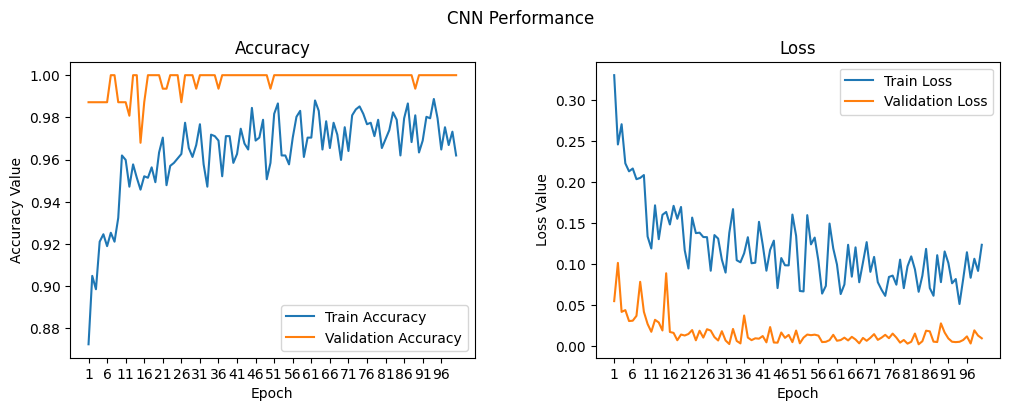

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


#Save the model
model.save('model.h5')

In [35]:
from tensorflow.keras.models import load_model

# Load the saved model  if you want to load the model without trining again
model = load_model('/content/drive/MyDrive/model.h5')  # Replace with the path to your saved model

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Convert the model to a TensorFlow SavedModel
tf.saved_model.save(model, "/content")


In [ ]:
import tensorflow as tf

# Load the TensorFlow SavedModel
saved_model_path ="/content/saved_model"
saved_model = tf.saved_model.load(saved_model_path)

# Convert the SavedModel to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
tflite_model_path = "/content"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to: {tflite_model_path}")


TypeError: Expected binary or unicode string, got <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7a44a7cccd60>

# 5.Testing and Evaluation:
In this phase, the trained model underwent rigorous evaluation on a distinct test set, consisting of 120 images not encountered during the training process. The model demonstrated exceptional performance, achieving a remarkable 100% accuracy on the test set.

# Evaluation Metrics:
Accuracy: 100%
Loss: 0.0056
Model's Strengths:
High Accuracy:
The model exhibited outstanding accuracy, showcasing its capability to effectively classify resumes based on visual features.

# Low Loss:
The low loss value (0.0059) indicates the model's proficiency in minimizing prediction errors during training and testing.

# Model's Limitations:
Caution for Overfitting: Achieving perfect accuracy raises concerns about potential overfitting, where the model may have memorized the training data. Cross-validation or evaluation on diverse datasets is recommended to confirm generalization.


In [36]:
class_names = ["empty", "not_empty"]

In [40]:
from PIL import Image
import numpy as np

# Load an image (adjust the path accordingly)
image_path = "/content/Data/not_empty/00000720_00000119.jpg"
image = Image.open(image_path)

# Preprocess the image if needed (resize, normalize, etc.)
# Example: Resize the image to the input size expected by the model
input_size = (150, 150)
image = image.resize(input_size)
image_array = np.array(image) / 255.0  # Normalize pixel values to be in the range [0, 1]

# Add an extra dimension to match the input shape expected by the model
image_array = np.expand_dims(image_array, axis=0)

# Predict using the model
y_pred = model.predict(image_array)
print(y_pred)

# Define the threshold
threshold = 0.5

# Convert probabilities to class labels using the threshold
predicted_class_label = 1 if y_pred[0][0] >= threshold else 0

# Optionally, you can also get the class name if needed
predicted_class_name = class_names[predicted_class_label]

print(f"Predicted Class Label: {predicted_class_label}")
print(f"Predicted Class Name: {predicted_class_name}")

1/1 [==============================] - 0s 31ms/step
[[0.9861362]]
Predicted Class Label: 1
Predicted Class Name: not_empty
